
# IMPORT LIBRARY
---



In [1]:
!pip install tensorflow

In [2]:
import tensorflow as tf
print(tf.__version__)

2.17.0


In [3]:
!pip install kaggle
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [4]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

## DATA PREOROCESSING

In [7]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [8]:
!kaggle datasets download -d adityamahimkar/iqothnccd-lung-cancer-dataset
!unzip iqothnccd-lung-cancer-dataset.zip -d lung_cancer_dataset

Dataset URL: https://www.kaggle.com/datasets/adityamahimkar/iqothnccd-lung-cancer-dataset
License(s): copyright-authors
 99% 197M/199M [00:13<00:00, 15.7MB/s]
100% 199M/199M [00:13<00:00, 15.0MB/s]
Archive:  iqothnccd-lung-cancer-dataset.zip
  inflating: lung_cancer_dataset/Test cases/000001_03_01_088.png  
  inflating: lung_cancer_dataset/Test cases/000017_02_01_016.png  
  inflating: lung_cancer_dataset/Test cases/000019_01_01_021.png  
  inflating: lung_cancer_dataset/Test cases/000019_02_01_025.png  
  inflating: lung_cancer_dataset/Test cases/000019_03_01_025.png  
  inflating: lung_cancer_dataset/Test cases/000020_01_01_066.png  
  inflating: lung_cancer_dataset/Test cases/000020_02_01_062.png  
  inflating: lung_cancer_dataset/Test cases/000020_03_01_134.png  
  inflating: lung_cancer_dataset/Test cases/000020_03_01_166.png  
  inflating: lung_cancer_dataset/Test cases/000020_03_01_212.png  
  inflating: lung_cancer_dataset/Test cases/000020_04_01_116.png  
  inflating: lung_can

In [11]:
data_dir = '/content/lung_cancer_dataset/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset'

categories = ['Bengin cases', 'Malignant cases', 'Normal cases']

img_size = 224
def load_images(data_dir, categories):
    data = []
    labels = []

    for category in categories:
        path = os.path.join(data_dir, category)
        class_num = categories.index(category)  # ทำให้เป็นตัวเลข

        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_img = cv2.resize(img_array, (img_size, img_size))
                data.append(resized_img)
                labels.append(class_num)
            except Exception as e:
                print(e)

    return np.array(data), np.array(labels)

# โหลดภาพและ labels
data, labels = load_images(data_dir, categories)

In [12]:
# Normalization ของข้อมูลรูปภาพ
data = data / 255.0
data = np.expand_dims(data, axis=-1)  # เพิ่ม dimension ให้กับภาพ grayscale

In [13]:
# One-hot encoding สำหรับ labels
labels = to_categorical(labels, num_classes=len(categories))

In [14]:
# แบ่งข้อมูลเป็น train, test, และ validation sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)

## BUILD CNN

In [21]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input

model = Sequential()

model.add(Input(shape=(img_size, img_size, 1)))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flattening Layer
model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # ใช้ Dropout เพื่อลดการ Overfitting

# Output Layer
model.add(Dense(len(categories), activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 222, 222, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,168,771 (42.61 MB)

 Trainable params: 11,168,771 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)

In [23]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, callbacks=[early_stopping])

Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 0.4431 - loss: 0.9997 - val_accuracy: 0.6591 - val_loss: 0.7399
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.6063 - loss: 0.8704 - val_accuracy: 0.7500 - val_loss: 0.6177
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.6624 - loss: 0.7726 - val_accuracy: 0.7614 - val_loss: 0.6003
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.7395 - loss: 0.6541 - val_accuracy: 0.8864 - val_loss: 0.4263
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.7746 - loss: 0.5440 - val_accuracy: 0.8864 - val_loss: 0.3824
Epoch 6/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.8167 - loss: 0.4790 - val_accuracy: 0.9318 - val_loss: 0.2635
Epoch 7/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.8631 - loss: 0.3803 - val_accuracy: 0.9205 - val_loss: 0.2545
Epoch 8/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.8775 - loss: 0.3284 - val_accuracy: 0.9659 - 

In [25]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc:.2f}')


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 247ms/step - accuracy: 0.9877 - loss: 0.0345
Test accuracy: 0.99


In [26]:
model.save('lung_cancer_cnn_model.keras')

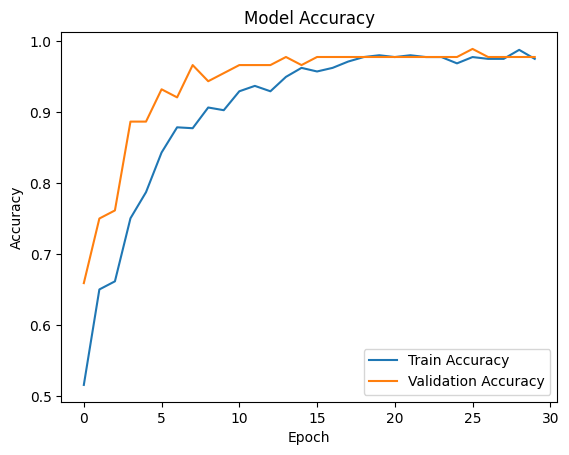

In [28]:
import matplotlib.pyplot as plt

# แสดงผลการเทรน
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()


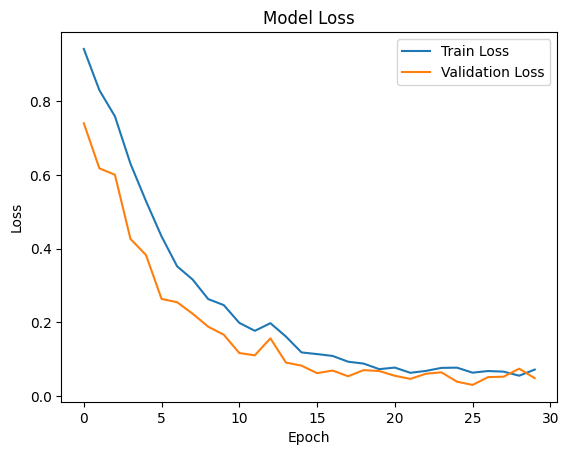

In [29]:
# แสดงผลการสูญเสีย
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [30]:
from tensorflow.keras.models import load_model

model = load_model('lung_cancer_cnn_model.keras')

# ใช้โมเดลเพื่อทำนาย
predictions = model.predict(X_test)  # X_test คือข้อมูลภาพที่ต้องการทำนาย

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step


In [31]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print(f'Test accuracy: {test_acc:.2f}')

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.9877 - loss: 0.0345
Test accuracy: 0.99


In [34]:
def load_images(data_dir, categories):
    data = []
    labels = []

    for category in categories:
        path = os.path.join(data_dir, category)
        class_num = categories.index(category)  # ทำให้เป็นตัวเลข

        for img in os.listdir(path):
            try:
                img_path = os.path.join(path, img)
                img_array = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

                # ตรวจสอบว่าภาพถูกโหลดหรือไม่
                if img_array is None:
                    print(f"Cannot load image: {img_path}")
                    continue

                resized_img = cv2.resize(img_array, (img_size, img_size))
                data.append(resized_img)
                labels.append(class_num)
            except Exception as e:
                print(f"Error processing image {img_path}: {e}")

    return np.array(data), np.array(labels)

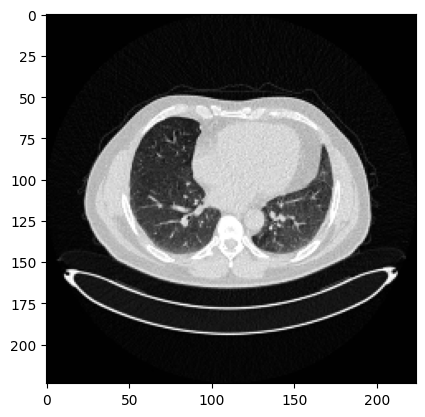

In [35]:
import matplotlib.pyplot as plt

plt.imshow(data[0], cmap='gray')
plt.show()

In [36]:
def load_images(data_dir, categories):
    data = []
    labels = []

    for category in categories:
        path = os.path.join(data_dir, category)
        class_num = categories.index(category)  # ทำให้เป็นตัวเลข

        for img in os.listdir(path):
            try:
                img_path = os.path.join(path, img)
                img_array = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

                # ตรวจสอบว่าภาพถูกโหลดสำเร็จหรือไม่
                if img_array is None:
                    print(f"Cannot load image: {img_path}")
                    continue

                resized_img = cv2.resize(img_array, (img_size, img_size))
                data.append(resized_img)
                labels.append(class_num)
            except Exception as e:
                print(f"Error processing image {img_path}: {e}")

    return np.array(data), np.array(labels)

In [38]:
import cv2
import numpy as np

img = cv2.imread('/content/lung_cancer_dataset/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/Bengin cases/Bengin case (101).jpg', cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (img_size, img_size))
img = np.expand_dims(img, axis=0)  # เพิ่ม dimension เพื่อให้เหมือนกับข้อมูล input

# ทำนาย
prediction = model.predict(img)
predicted_class = np.argmax(prediction)
print(f'Predicted class: {categories[predicted_class]}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step
Predicted class: Bengin cases


In [39]:
import cv2
import numpy as np

# ฟังก์ชันสำหรับโหลดและเตรียมภาพใหม่
def load_new_image(image_path, img_size):
    img_array = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # อ่านภาพในแบบ grayscale
    if img_array is None:
        print(f"Cannot load image: {image_path}")
        return None
    resized_img = cv2.resize(img_array, (img_size, img_size))  # resize ภาพให้มีขนาดเท่ากับที่ใช้ฝึก
    normalized_img = resized_img / 255.0  # ทำ normalization ให้ค่าพิกเซลอยู่ในช่วง 0-1
    normalized_img = np.expand_dims(normalized_img, axis=-1)  # เพิ่ม dimension ให้กับภาพ (grayscale)
    normalized_img = np.expand_dims(normalized_img, axis=0)  # เพิ่ม batch dimension
    return normalized_img

In [40]:
import os

test_cases_folder = '/content/lung_cancer_dataset/Test cases'

# วนลูปทำนายภาพใหม่ทั้งหมด
for img_file in os.listdir(test_cases_folder):
    image_path = os.path.join(test_cases_folder, img_file)
    new_image = load_new_image(image_path, img_size)

    if new_image is not None:
        prediction = model.predict(new_image)
        predicted_class = np.argmax(prediction)
        print(f'Image: {img_file}, Predicted class: {categories[predicted_class]}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
Image: 000103_01_01_104.png, Predicted class: Normal cases
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Image: 000020_01_01_066.png, Predicted class: Normal cases
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Image: 001083_09_01_093.png, Predicted class: Malignant cases
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Image: 002639_05_01_141.png, Predicted class: Malignant cases
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Image: 000019_03_01_025.png, Predicted class: Normal cases
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Image: 000103_13_02_092.png, Predicted class: Normal cases
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Image: 000185_02_04_174.png, Predicted class: Bengin cases
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Image: 000266_03_02_133.png, Predicted class: Normal cases
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Image: 000247_04_01_165.png, Predicted class: Malignant cases
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Image: 001598_15_02_231.png, Predicted class: Malignant cases
1/1 ━━━━━━━━━━━━━

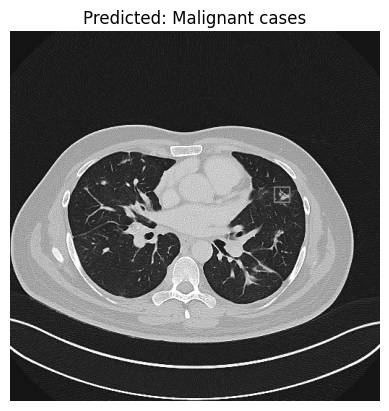

In [41]:
import matplotlib.pyplot as plt

def show_prediction(image_path, predicted_class):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    plt.imshow(img, cmap='gray')
    plt.title(f"Predicted: {categories[predicted_class]}")
    plt.axis('off')
    plt.show()

# แสดงภาพที่ทำการทำนาย
show_prediction(image_path, predicted_class)

In [43]:
true_labels = {
    '/content/lung_cancer_dataset/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/Bengin cases/Bengin case (1).jpg': 'Benign cases',
    '/content/lung_cancer_dataset/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/Malignant cases/Malignant case (100).jpg': 'Malignant cases',
    '/content/lung_cancer_dataset/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/Normal cases/Normal case (102).jpg': 'Normal cases'
}

image_name = '/content/lung_cancer_dataset/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/Normal cases/Normal case (102).jpg'
image_path = os.path.join('/content/lung_cancer_dataset/Test cases', image_name)
new_image = load_new_image(image_path, img_size)

if new_image is not None:
    prediction = model.predict(new_image)
    predicted_class = np.argmax(prediction)
    predicted_label = categories[predicted_class]

    # ดูว่าโมเดลทำนายถูกหรือไม่
    if predicted_label == true_labels[image_name]:
        print(f"Correct Prediction for {image_name}: {predicted_label}")
    else:
        print(f"Incorrect Prediction for {image_name}. Predicted: {predicted_label}, True: {true_labels[image_name]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Correct Prediction for /content/lung_cancer_dataset/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/Normal cases/Normal case (102).jpg: Normal cases


## ปรับปรุงโมเดล

In [45]:
# สมมติว่า labels_list เป็นลิสต์ของตัวเลขที่แทน categories
labels_list = [0, 1, 0, 2, 1, 0, 2]  # ลิสต์ของค่าตัวเลขที่แทน categories

categories = ['Benign', 'Malignant', 'Normal']
for label in labels_list:
    print(categories[label])

Benign
Malignant
Benign
Normal
Malignant
Benign
Normal


In [46]:
print(labels_list)

[0, 1, 0, 2, 1, 0, 2]


In [47]:
correct_predictions = 0
total_images = len(true_labels)

for image_name in true_labels.keys():
    image_path = os.path.join('Test cases', image_name)
    new_image = load_new_image(image_path, img_size)

    if new_image is not None:
        prediction = model.predict(new_image)
        predicted_class = np.argmax(prediction)
        predicted_label = categories[predicted_class]

        if predicted_label == true_labels[image_name]:
            correct_predictions += 1

# คำนวณความแม่นยำ
accuracy = correct_predictions / total_images
print(f"Model Accuracy: {accuracy * 100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Model Accuracy: 0.00%


## ตรวจสอบความแม่นยำของโมเดล

In [52]:
# ตรวจสอบความแม่นยำของโมเดลบนชุดทดสอบ
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print(f'Test accuracy: {test_acc * 100:.2f}%')

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.9877 - loss: 0.0345
Test accuracy: 98.64%


In [53]:
predictions = model.predict(X_test)

# หา label ที่โมเดลทำนาย (ใช้ np.argmax ถ้าเป็น one-hot encoded)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

# คำนวณความแม่นยำ
accuracy = np.mean(predicted_classes == true_classes)
print(f'Test accuracy: {accuracy * 100:.2f}%')

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
Test accuracy: 98.64%


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


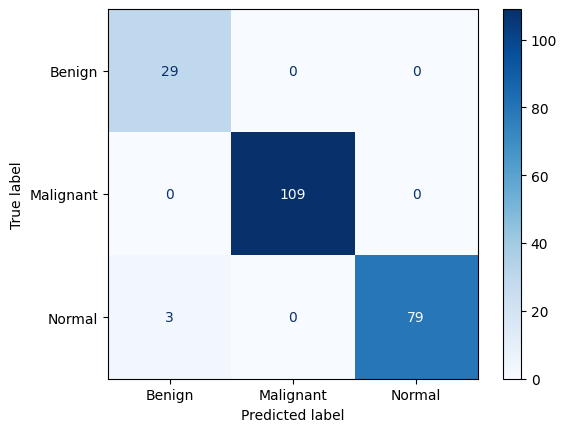

In [55]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# ทำนายผลลัพธ์จากโมเดล
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

cm = confusion_matrix(true_classes, predicted_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [33]:
from tensorflow.keras.models import load_model
model = load_model('/content/lung_cancer_cnn_model.keras')